<a href="https://colab.research.google.com/github/andreacangiani/NSPDE-ANA2024/blob/main/Python/CP4_worked.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 4

Finite Difference solver for the 2D Poisson problem:

$-\Delta u=f \quad \in \Omega=(a,b)^2$

$u|_{\partial\Omega}=0$

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve

Function computing the 2D FD algebric system

In [15]:
omega = [0, 1]
N = 3

h = (omega[1] - omega[0]) / N
x = np.linspace(omega[0], omega[1], N + 1)
y = x
# 2-dim grid
X, Y = np.meshgrid(x, y)

X = X.flatten()
Y = Y.flatten()

print(X)
print(Y)

[ 0  0  1  1  0  0  1  1  0  0  1  1  0  0  1  1]
[ 0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1]


In [16]:
def FD2D(omega, N, rhs):

  h = (omega[1] - omega[0]) / N
  x = np.linspace(omega[0], omega[1], N + 1)
  y = x

  X, Y = np.meshgrid(x, y)
  X = X.flatten()
  Y = Y.flatten()

  F = rhs(X, Y)

  # system matrix
  # -(1/h^2) (U_{i,j-1} + U_{i-1,j}) - 4 * U_{i,j} + U_{i+1,j} + U_{i,j+1} )
  coefs = [-1 * np.ones((N + 1) * N),
           -1 * np.ones((N + 1) * (N + 1) -1),
           4 * np.ones((N + 1) * (N + 1)),
           -1 * np.ones((N + 1) * (N + 1) - 1),
           -1 * np.ones((N + 1) * N)]
  
  A = sp.diags(coefs, [-(N + 1), -1, 0, 1, N + 1], format="lil") # Avoids SparseEfficiencyWarning

  # boundary conditions
  for i in range(N + 1):
    # y = a
    A[i, :] = 0; A[i, i] = 1; F[i] = 0
    
    # y = b
    j = (N + 1) * N + i
    A[j, :] = 0; A[j, j] = 1; F[j] = 0
    
  for i in range(1, N):
    # x = a
    j = i * (N + 1)
    A[j, :] = 0; A[j, j] = 1; F[j] = 0
    
    # x = b
    j = i * (N + 1) + N
    A[j, :] = 0; A[j, j] = 1; F[j] = 0

  A = A.tocsr()
  return (1. / h**2) * A, F

Define FD problem and solve with $(a,b)=(0,
pi)$ and

$u(x,y)=sin(x)*sin(y)$

hence

$f=2* sin(x)*sin(y)$

In [19]:
# Problem data
omega = [0, 1]
N = 10
rhs = lambda x, y : 2 * np.sin(x) * np.sin(y)
u = lambda x, y : np.sin(x) * np.sin(y)

A, F = FD2D(omega, N, rhs)
uh = spsolve(A, F)

Plot solution

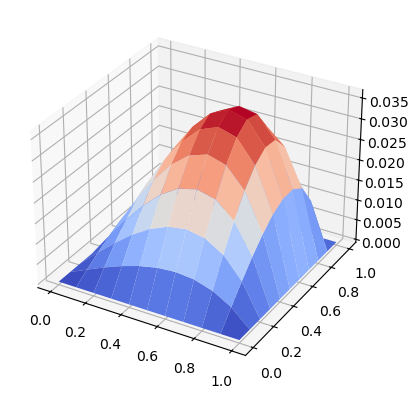

In [20]:
x = np.linspace(omega[0], omega[1], N + 1)

X, Y = np.meshgrid(x, x)
Uh = uh.reshape((N + 1),(N + 1))

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, Uh, cmap=cm.coolwarm, linewidth=0, antialiased=True)

plt.show()

Compute discrete max norm error

In [21]:
print(np.max(np.abs(u(X,Y) - Uh)))

0.7080734182735712


## Exercise 1

Run a series of experiments each time halfing the mesh size to each time computing the error and the EOC

In [22]:
omega = [0, np.pi]
rhs = lambda x, y : 2 * np.sin(x) * np.sin(y)
u = lambda x, y : np.sin(x) * np.sin(y)

N = 2
x = np.linspace(omega[0], omega[1], N + 1)
X, Y = np.meshgrid(x, x)
U = u(X, Y).flatten()

A, F = FD2D(omega, N, rhs)
uh = spsolve(A, F)

err1 = np.max(np.abs(U - uh))
h1 = (omega[1] - omega[0]) / N

for N in [2**i for i in range(2, 9)]:
    x = np.linspace(omega[0], omega[1], N + 1)
    X, Y = np.meshgrid(x, x)
    U = u(X, Y).flatten()

    A, F = FD2D(omega, N, rhs)
    uh = spsolve(A, F)

    err2 = np.max(np.abs(U - uh))
    h2 = (omega[1] - omega[0]) / N

    eoc = np.around((np.log(err1) - np.log(err2)) / (np.log(h1) - np.log(h2)), 4)

    print(f'error: {np.around(err1, 5)} EOC: {eoc}')

    err1 = err2
    h1 = h2

error: 0.2337 EOC: 2.1398
error: 0.05303 EOC: 2.0338
error: 0.01295 EOC: 2.0084
error: 0.00322 EOC: 2.0021
error: 0.0008 EOC: 2.0005
error: 0.0002 EOC: 2.0001
error: 5e-05 EOC: 2.0


## Exercise 2

Generalise the FD2D routine to assemble more general elliptic problems. For instance, solve

-$\alpha \Delta u + {\bf b}\cdot \nabla u + c u =f\, $ in $\, \Omega$,

with homogeneous Dirichlet and nonhomogeneous Dirichlet boundary conditions.

Write a program to test your routine and check EOC.

In [23]:
def FD2D_general(omega, N, alpha, b, c, rhs, bc_left, bc_right, bc_bottom, bc_top):
    h = (omega[1] - omega[0]) / N
    x = np.linspace(omega[0], omega[1], N + 1)
    y = x

    X, Y = np.meshgrid(x, y)
    X = X.flatten()
    Y = Y.flatten()

    alpha_values = alpha(X, Y)
    bx_values, by_values = b(X, Y)
    c_values = c(X, Y)
    F = rhs(X, Y)

    A = sp.lil_matrix(((N + 1) * (N + 1), (N + 1) * (N + 1)))

    # stencil
    for j in range(1, N):
        for i in range(1, N):
            k = i + j * (N + 1)
            
            A[k, k] = 4 * alpha_values[k] / h**2 + c_values[k]  # Center
            A[k, k - 1] = -alpha_values[k] / h**2 - bx_values[k] / (2 * h)  # Left
            A[k, k + 1] = -alpha_values[k] / h**2 + bx_values[k] / (2 * h)  # Right
            A[k, k - (N + 1)] = -alpha_values[k] / h**2 - by_values[k] / (2 * h)  # Down
            A[k, k + (N + 1)] = -alpha_values[k] / h**2 + by_values[k] / (2 * h)  # Up

    # Boundary conditions
    for i in range(N + 1):
        # y = a (bottom boundary)
        A[i, :] = 0
        A[i, i] = 1
        F[i] = bc_bottom(x[i])
        
        # y = b (top boundary)
        j = (N + 1) * N + i
        A[j, :] = 0
        A[j, j] = 1
        F[j] = bc_top(x[i])
        
    for i in range(1, N):
        # x = a (left boundary)
        j = i * (N + 1)
        A[j, :] = 0
        A[j, j] = 1
        F[j] = bc_left(y[i])
        
        # x = b (right boundary)
        j = i * (N + 1) + N
        A[j, :] = 0
        A[j, j] = 1
        F[j] = bc_right(y[i])

    A = A.tocsr()
    return A, F

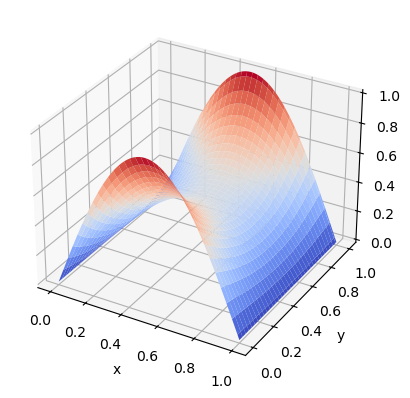

In [24]:
omega = [0, 1]
N = 100

alpha = lambda x, y: np.ones_like(x)
b = lambda x, y: (np.ones_like(x), np.ones_like(y))
c = lambda x, y: np.zeros_like(x)
rhs = lambda x, y: np.ones_like(x)

bc_left = lambda y: np.zeros_like(y) #np.sin(np.pi * y)
bc_right = lambda y: np.zeros_like(y) #np.sin(np.pi * y)
bc_bottom = lambda x: np.sin(np.pi * x)
bc_top = lambda x: np.sin(np.pi * x)

A, F = FD2D_general(omega, N, alpha, b, c, rhs, bc_left, bc_right, bc_bottom, bc_top)
uh = spsolve(A, F)

Uh = uh.reshape((N + 1, N + 1))

x = np.linspace(omega[0], omega[1], N + 1)
y = x
X, Y = np.meshgrid(x, y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Uh, cmap=cm.coolwarm)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u')
plt.show()

In [74]:
uh_prev = None
err_prev = None
theta = 0.5

for N in [2**i for i in range(2, 10)]:
    A, F = FD2D_general(omega, N, alpha, b, c, rhs, bc_left, bc_right, bc_bottom, bc_top)
    uh = spsolve(A, F)
    
    Uh = uh.reshape((N + 1, N + 1))

    if uh_prev is not None:
        uh_coarsened = Uh[::2, ::2].flatten()

        err = np.max(np.abs(uh_coarsened - uh_prev))
        
        if err_prev is not None:
            k = np.log(err / err_prev) / np.log(theta)
            print(f'Estimated EOC: {np.around(k, 4)} (N = {N})')
        
        err_prev = err

    # Update uh_prev for the next iteration
    uh_prev = Uh.flatten()


Estimated EOC: 1.9395 (N = 16)
Estimated EOC: 1.9658 (N = 32)
Estimated EOC: 1.9959 (N = 64)
Estimated EOC: 1.9976 (N = 128)
Estimated EOC: 1.9996 (N = 256)
Estimated EOC: 1.9999 (N = 512)
